In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import math
import statistics as stats
import praw
from textblob import TextBlob
from datetime import datetime, timedelta

In [2]:
#authentication for praw
my_client_id = "-vOTMtJazmzppQ"
my_client_secret = "_cXn_GBKUTHrDPGsZxjQOV9Vz-A"
my_user_agent = "web:scraper.v0 (by u/skeet__)"

In [94]:
#_____FUNCTIONS_____#

def getStockInfo(stock):
    
    #Compute the last days of stock to fetch
    
    today = datetime.today();
    #date in string form to use for fetching the data
    date_extrac = today.strftime("%Y-%m-%d")
    #current time
    now = datetime.now()
    #The time when market closes
    End_of_day = now.replace(hour=16, minute=0, second=0, microsecond=0)
    #Checks if the market is closed or not. If yes then fetch the stock 
    #data till today. However if the market is not closed then we can fetch 
    #the data till yesterday.
    if now > End_of_day:
        #Increment the day because end in yf.download fetches day - 1
        today = datetime.today()+timedelta(1)
        date_extrac = today.strftime("%Y-%m-%d")
        
    data =  yf.download(stock, start="2008-06-07", end = date_extrac)
    #get just adjusted close
    close = data['Adj Close']
    #get close, open, high, low, and volume
    data = data[["Close", "Open", "High", "Low", "Volume"]]
    
    
    ##RSI (code from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas)
    #get the difference in close price from previous step
    delta = close.diff()
    #get rid of the first row of delta which is NaN
    delta = delta[1:] 
    #make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    #calculate the EWMA
    roll_up1 = up.ewm(span=20).mean()
    roll_down1 = down.abs().ewm(span=20).mean()
    
    #calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    data['RSI_EMA'] = RSI1
    
    # Calculate the SMA
    roll_up2 = up.rolling(20).mean()
    roll_down2 = down.abs().rolling(20).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    data['RSI_SMA'] = RSI2
    
    #calculate the simple moving average
    #20 days to represent the 22 trading days in a month
    data['MA20d'] = data['Close'].rolling(20).mean()
    data['MA50d'] = data['Close'].rolling(50).mean()
    
    #exponential moving average
    data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()
    
    #calculate upper and lower bollinger bands
    data['20dSTD'] = data['Close'].rolling(20).std()
    
    data['upperBand'] = data['MA20d'] + (data['20dSTD'] * 2)
    data['lowerBand'] = data['MA20d'] - (data['20dSTD'] * 2)
    
    #Drop the columns with NAN
    data.dropna(subset=None, inplace=True)
    return data

def getSentiment(companyName):
    #load news headlines
    df = pd.read_csv ('RedditNews.csv')
    #get sentiment for each headline
    df['News'] = df['News'].apply(lambda News: TextBlob(News).sentiment)
    #remove headlines that are completely neutral
    df = df[df['News'] != (0.0, 0.0)]
    #split the sentiment tuple (polarity, subjectivity) into two columns
    df_sentiment = pd.DataFrame(data=df['Date'])
    df_sentiment[['polarity', 'subjectivity']] = pd.DataFrame(df['News'].tolist(), index=df.index)
    #make a reddit instance to get news
    reddit = praw.Reddit(client_id=my_client_id, client_secret=my_client_secret, user_agent=my_user_agent)
    #subreddit to search - all
    subreddit = reddit.subreddit("all")
    #search "all" for posts from all time containing the company name
    search_result = subreddit.search(companyName, 'top', time_filter='all')
    #list to hold sentiments
    sentiments = []
    #loop through the search results
    for submission in search_result:
        if not submission.stickied:
            #get the sentiment for the post
            sentiments.append((datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d') ,
                              TextBlob(submission.title).sentiment))
    company_sentiments = pd.DataFrame(sentiments)
    company_filtered = company_sentiments[company_sentiments[1] != (0.0, 0.0)]
    #split the sentiment tuple (polarity, subjectivity) into two columns
    company_df = pd.DataFrame(data=company_sentiments[0])
    company_df[['polarity', 'subjectivity']] = pd.DataFrame(company_filtered[1].tolist(), index=company_filtered.index)
    old_sentiments = pd.concat([df_sentiment, company_df])
    #get the mean sentiment for each day
    dfm = old_sentiments.groupby('Date').mean()
    #get the index of the dataframe into datetime format
    dfm.index = pd.to_datetime(dfm.index)
    #this will hold a list of sentiments for today's news
    sentiment_today = []
    #subreddit to search - all
    subreddit = reddit.subreddit("all")
    #search "all" for posts containin company name
    search_result = subreddit.search(companyName, 'relevance', time_filter='day')
    #loop through the search results
    for submission in search_result:
        if not submission.stickied:
            #get the sentiment for the post
            sentiment_today.append(TextBlob(submission.title).sentiment)
    #remove headlines that are completely neutral        
    filtered_today = np.array([sentiment for sentiment in sentiment_today if sentiment != (0,0)])
    #mean sentiment for today
    mean_today = np.mean(filtered_today, axis=0)
    #put it in a dataframe
    today_df = pd.DataFrame({'polarity': mean_today[0], 'subjectivity': mean_today[1]}, index = [datetime.now().date()])
    #sentiments from dataset + sentiment today
    sentiments = pd.concat([dfm, today_df])
    #make an index date range for the beginning of the headlines dataset to today
    idx = pd.date_range('06-08-2008', datetime.now().date())
    #fill missing dates with 0
    sentiments = sentiments.reindex(idx, fill_value=0)
    return sentiments
    
    
def splitDataSet(dataset):
    #train/test split will be 80/20
    training_data_len = math.ceil(len(dataset)*.75)
    
    #Create train dataset
    train_data = dataset[0:training_data_len]
    #create test dataset
    test_data = dataset[training_data_len-60:]
    
    #Scale the data
    train_scaler = MinMaxScaler(feature_range=(0,1))
    test_scaler = MinMaxScaler()
    scaled_train = train_scaler.fit_transform(train_data)
    scaled_test = test_scaler.fit_transform(test_data)
     
    X_train = []
    y_train = []
    for i in range(60, len(train_data)):
        X_train.append(scaled_train[i-60:i])
        y_train.append(scaled_train[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test = []
    y_test = []
    for i in range(60, test_data.shape[0]):
        X_test.append(scaled_test[i-60:i])
        y_test.append(scaled_test[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    return [X_test, y_test, X_train, y_train, test_scaler]

#LSTM model
def makeModel(X_train):
    model = Sequential()

    model.add(LSTM(units = 40, activation = 'linear',return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 40, activation = 'linear',return_sequences = True))
    model.add(Dropout(0.2))
    

    model.add(LSTM(units = 64, activation = 'linear'))
    model.add(Dropout(0.2))
    

    model.add(Dense(10))
    model.add(Dense(1))
    
    
    #compile the model
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    return model

def getyhat(dataset, test_scaler):
        
    test_index = dataset.iloc[-y_test.shape[0]:].index
    test_index = test_index+timedelta(1)
    y_test_reshaped = np.reshape(y_test,(y_test.shape[0], 1))
    test_unscaler = MinMaxScaler()
    test_unscaler.min_, test_unscaler.scale_ = test_scaler.min_[0], test_scaler.scale_[0]
    y_test_unscaled = test_unscaler.inverse_transform(y_test_reshaped)
    y_test_df = pd.DataFrame(data=y_test_unscaled, columns=['Close']).set_index(test_index)
    
    yhat = model.predict(X_test)
    yhat_unscaled = test_unscaler.inverse_transform(yhat)
    yhat_df = pd.DataFrame(data=yhat_unscaled, columns=['Close']).set_index(test_index)
    return [yhat ,yhat_df, y_test_df]

def plotLoss(hist):
    # plot loss
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='test')
    plt.legend()
    plt.show()

def graphResults(yhat_df, y_test_df, stock_name):
    # Visualising the results
    plt.figure(figsize=(14,5))
    plt.plot(y_test_df, color = 'red', label = "Real {stock} stock price".format(stock = stock_name))
    plt.plot(yhat_df, color = 'blue', label = "Predicted {stock} stock Price".format(stock = stock_name))
    plt.title("{stock} Stock Prediction".format(stock = stock_name))
    plt.legend()
    plt.show()


In [89]:
#_____MAIN_START_____#
#ask the user for a ticker symbol
while True:
    ticker = input("Enter the stock symbol/ticker you'd like to predict: ").upper()
    if ticker == "":
        ticker = "AAPL"
    try:
        data = getStockInfo(ticker)
    except:
        print("No data found, symbol may be delisted")
        continue
    else:
        break

#ask the user if they would like to include news sentiments in the prediction
print('would you like to include news sentiments in the data?\nplease enter "y" or "n" (if sentiments are not included, prediction will be made using price data only)')
response = input()
if (response == "y"):
    #get the sentiments
    print("getting sentiments...")
    sentiments = getSentiment(ticker)
    #put the sentiments into data
    full = pd.concat([data, sentiments], axis=1, sort=False)
    #drop rows with NaN
    full = full.dropna(axis=0)
else:
    full = data

#put the dataset into a numpy array
dataset = full.to_numpy()

#set up data sets
X_test, y_test, X_train, y_train, test_scaler = splitDataSet(dataset)

Enter the stock symbol/ticker you'd like to predict: aal
[*********************100%***********************]  1 of 1 completed
would you like to include news sentiments in the data?
please enter "y" or "n" (if sentiments are not included, prediction will be made using price data only)
n


In [90]:
model = makeModel(X_train)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 40)            8640      
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 40)            12960     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                26880     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [91]:
print("training model...")
hist = model.fit(X_train, y_train, epochs=3, batch_size=60, validation_data = (X_test, y_test))

training model...
Epoch 1/3
40/40 [==============================] - 3s 82ms/step - loss: 0.0485 - val_loss: 0.0075
Epoch 2/3
40/40 [==============================] - 3s 71ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 3/3
40/40 [==============================] - 3s 71ms/step - loss: 0.0058 - val_loss: 0.0049


loss plot


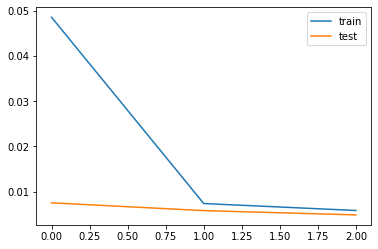

In [92]:
print("loss plot")
plotLoss(hist)

In [95]:
#make prediction
print("making prediction...")
yhat, yhat_df, y_test_df = getyhat(full, test_scaler)

#Show the predicted Close price for next day
print(yhat_df.tail(1))

making prediction...
                Close
Date                 
2021-05-15  22.301413


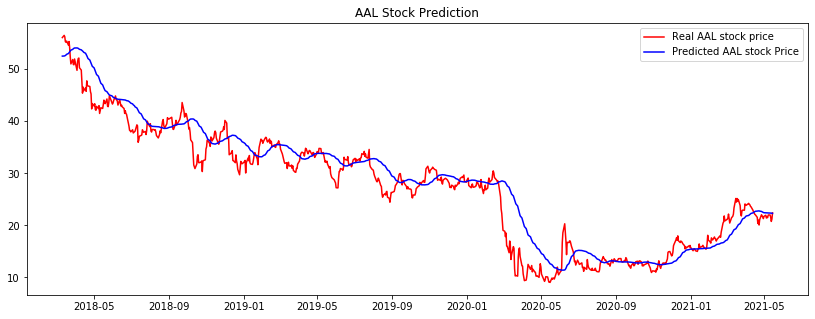

In [96]:
#plot results
graphResults(yhat_df, y_test_df, ticker)

In [97]:
#accuracy metric
rmse = math.sqrt(mean_squared_error(y_test_df, yhat_df))
print('Test RMSE: %.3f' % rmse)
NRMSE = (rmse/(np.max(y_test_df)-np.min(y_test_df)))*100
print('NRMSE = %.2f%%' % NRMSE)

Test RMSE: 3.449
NRMSE = 7.27%
